# **TUAN**

In [ ]:
# Thêm thư viện
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Lấy dữ liệu từ bộ MNIST
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Tiền xử lý dữ liệu, reshape từ ảnh xám 28*28 thành vector 784 chiều và đưa dữ liệu từ scale [0, 255] về [0, 1]
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [ ]:
# Số chiều noise vector
z_dim = 100

In [ ]:
# Optimizer
adam = Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
# Mô hình Generator
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
# Vì dữ liệu ảnh MNIST đã chuẩn hóa về [0, 1] nên hàm G khi sinh ảnh ra cũng cần sinh ra ảnh có pixel value trong khoảng [0, 1] => hàm sigmoid được chọn
g.add(Dense(784, activation='sigmoid'))  
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# Mô hình Discriminator
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
# Hàm sigmoid cho bài toán binary classification 
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# Hàm vẽ loss function
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Hàm vẽ sample từ Generator
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
image_batch = X_train[np.random.randint(0, X_train.shape[0], size=128)]
print(image_batch.shape)

noise = np.random.normal(0, 1, size=(128, z_dim))
print(noise.shape)

(128, 784)
(128, 100)


In [ ]:
# Lưu giá trị loss và accuracy của Discriminator và Generator
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128): # batch_size: 128 images for each training
    # Tính số lần chạy trong mỗi epoch
    batchCount = int(X_train.shape[0] / BATCH_SIZE) #60000/128
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Lấy ngẫu nhiên các ảnh từ MNIST dataset (ảnh thật)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Sinh ra noise ngẫu nhiên
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Dùng Generator sinh ra ảnh từ noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images)) # X is concat REAL vs FAKE image
            # Tạo label
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # gán label bằng 0.9 cho những ảnh từ MNIST dataset và 0 cho ảnh sinh ra bởi Generator

            # Train discriminator
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            # Khi train Generator gán label bằng 1 cho những ảnh sinh ra bởi Generator -> cố gắng lừa Discriminator. 
            y2 = np.ones(BATCH_SIZE)
            # Khi train Generator thì không cập nhật hệ số của Discriminator.
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Lưu loss function
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Vẽ các số được sinh ra để kiểm tra kết quả
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 100
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/100 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


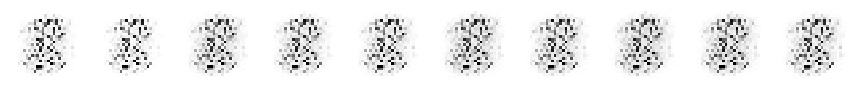

--------------- Epoch 20 ---------------


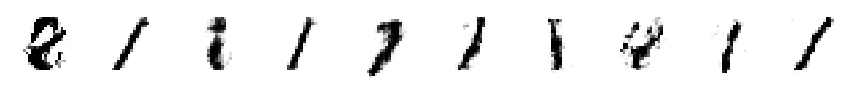

--------------- Epoch 40 ---------------


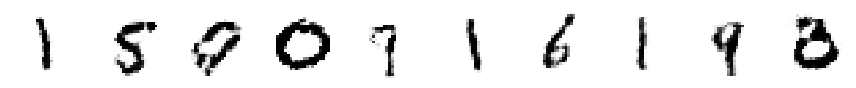

--------------- Epoch 60 ---------------


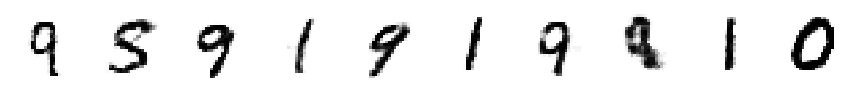

--------------- Epoch 80 ---------------


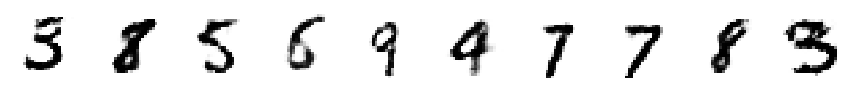

--------------- Epoch 100 ---------------


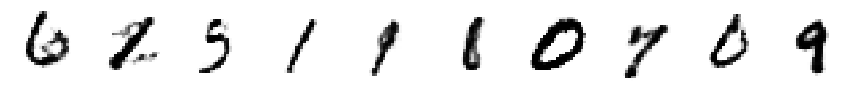

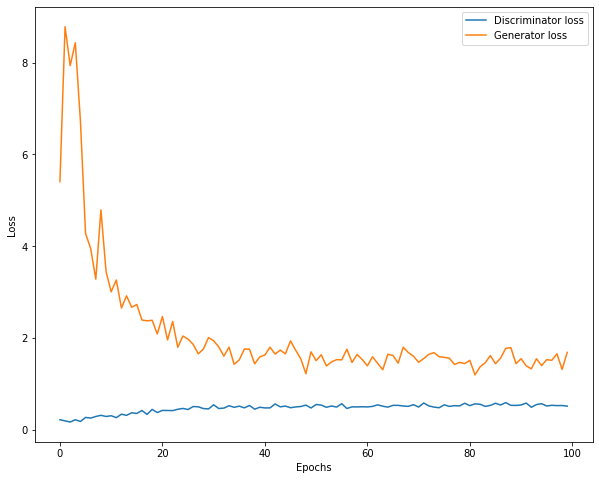

In [ ]:
train(epochs=100, plt_frq=20, BATCH_SIZE=128)

## **Pham Dinh Khanh**

In [12]:
# Load dữ liệu mnist
from tensorflow.keras.datasets.mnist import load_data
(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


Hiển thị một số hình ảnh của mnist. Đây là một bước quan trọng để các bạn hình dung dữ liệu như thế nào? chất lượng dữ liệu ra sao. Đừng bao giờ xây dựng mô hinh luôn mà không nhìn vào dữ liệu nhé.

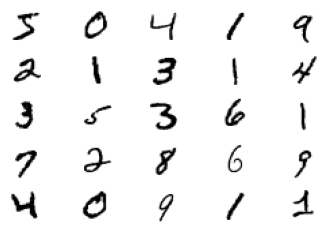

In [13]:
import matplotlib.pyplot as plt

# plot images from the training dataset
def _plot(X):
	for i in range(25):
		# define subplot
		plt.subplot(5, 5, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(X[i], cmap='gray_r')
	plt.show()
 
_plot(trainX[:25, :])

Như vậy dữ liệu của chúng ta là những chữ số viết tay có kích thước tương đổi nhỏ, nét chữ màu đen và background màu trắng. Các chữ số đã được tiền xử lý để xuất hiện ở ngay trung tâm của ảnh.

**5.1. Discriminator**

Tiếp theo ta sẽ xác định descriminator model. Nhận xét đầu tiên đây sẽ là một mạng CNN nhận đầu vào là một bức ảnh có thể là real hoặc fake. Output sẽ gồm hai nhãn tương ứng với real và fake. Do đó chúng ta phải sử dụng activation là sigmoid.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


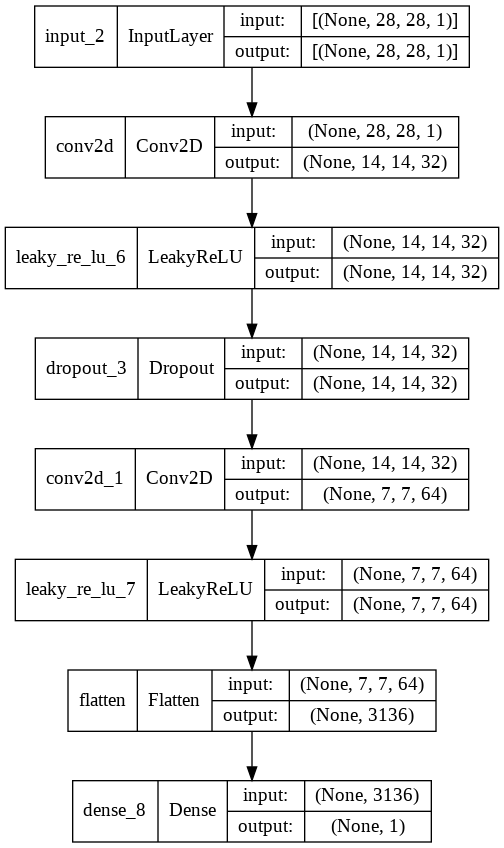

In [14]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, LeakyReLU, Dropout, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

def _discriminator():
  # Khai báo các layers
  inpt = Input(shape=(28, 28, 1))
  conv1 = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same')(inpt)
  act_leak1 = LeakyReLU(alpha=0.3)(conv1)
  dropout = Dropout(0.4)(act_leak1)
  conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same')(dropout)
  act_leak2 = LeakyReLU(alpha=0.3)(conv2)
  flat = Flatten()(act_leak2)
  den = Dense(1, activation='sigmoid')(flat)
  # Khởi tạo model
  model = Model(inputs = [inpt], outputs = [den])
  # Compile với optimizer
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

discriminator = _discriminator()
plot_model(discriminator, show_shapes=True)

**5.2 Generator**

Generator sẽ là một mô hình sinh ảnh từ nhiễu. Nhiễu đầu vào sẽ là một véc tơ phân phối gaussian với trung bình bằng 0 và phương sai bằng 1. Chúng ta sẽ reshape khối này về một tensor3D có kích thước là 7x7 và sử dụng mạng giải chập để giải chập về kích thước 28x28. Mạng giải chập là một tiến trình ngược với tích chập và rất hiệu quả trong các bài toán sinh ảnh.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


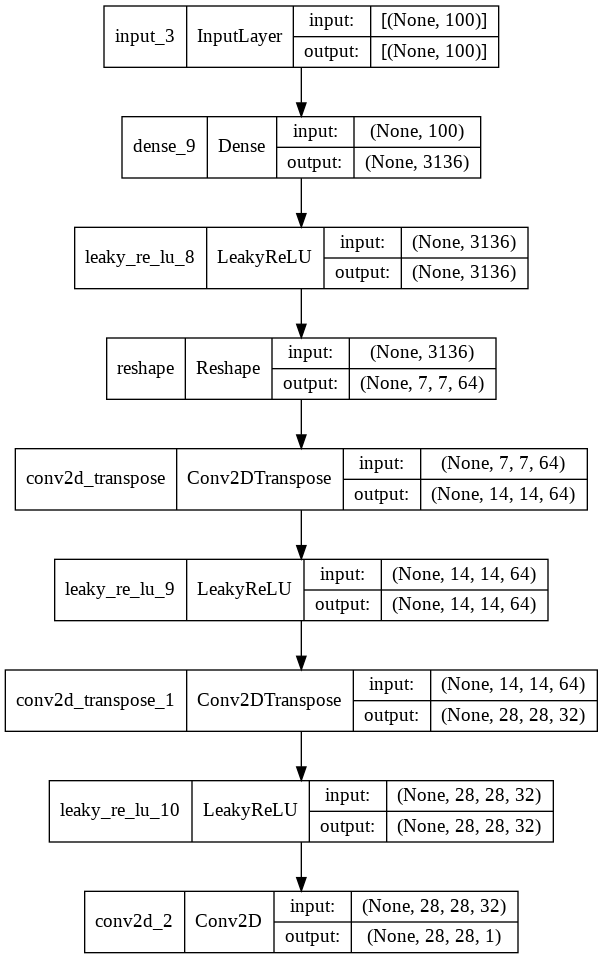

In [15]:
from tensorflow.keras.layers import Conv2DTranspose

def _generator(noise_size = 100):
  n_units = 64*7*7
  inpt = Input(shape=(noise_size))
  den1 = Dense(n_units)(inpt)
  act_leak1 = LeakyReLU(alpha=0.3)(den1)
  reshape = Reshape((7,7,64))(act_leak1)
  con2DTran1 = Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same')(reshape)
  act_leak2 = LeakyReLU(alpha=0.3)(con2DTran1)
  con2DTran2 = Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same')(act_leak2)
  act_leak3 = LeakyReLU(alpha=0.3)(con2DTran2)
  con = Conv2D(filters=1, kernel_size=(28, 28), activation='sigmoid', padding='same')(act_leak3)

  # Khởi tạo model
  model = Model(inputs = [inpt], outputs = [con])
  # Compile với optimizer
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

generator = _generator(noise_size = 100)
plot_model(generator, show_shapes=True)

Như vậy mạng CNN của Generator sẽ có các CNN layers theo thứ tự ngược lại so với Discriminator.

**5.3. GAN model**

Tiếp theo ta sẽ khởi tạo model GAN là kết hợp giữa Discriminator và Generator

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


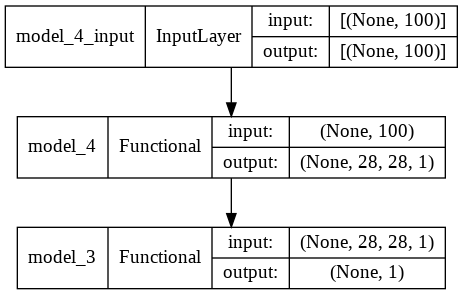

In [16]:
from tensorflow.keras.models import Sequential

def _gan(g_model, d_model):
  # Đóng băng weight của discriminator
	d_model.trainable = False
	# Khởi tạo model GAN
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# Khai báo số chiều của noise véc tơ input của generator.
latent_dim = 100
# Khởi tạo discriminator và generatator model
d_model = _discriminator()
g_model = _generator(latent_dim)
# Khởi tạo GAN model
gan_model = _gan(g_model, d_model)
plot_model(gan_model, show_shapes=True)

**5.4. Chọn mẫu real và fake**

Để quá trình hội tụ nhanh hơn thì chúng ta sẽ chuẩn hóa các giá trị của input về [0, 1] bằng cách chia giá trị của mỗi pixel cho 255.

In [17]:
def _normalize():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = X / 255.0
	return X

Dữ liệu fake sẽ được sinh một cách ngẫu nhiên từ một véc tơ có kích thước là latent_dim. Nhãn của dữ liệu fake sẽ được gán là 0.

In [18]:
import numpy as np

# Hàm sinh batch input là noise véc tơ cho generator
def generate_latent_points(latent_dim, n_samples):
	# khởi tạo input ngẫu nhiên
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape về batch
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 

# Hàm sinh batch cho fake sample, nhãn của fake sample là 0
def generate_fake_samples(g_model, latent_dim, n_samples):
	# sinh batch là các noise véc tơ
	x_input = generate_latent_points(latent_dim, n_samples)
	# dự báo outputs từ g_model
	X = g_model.predict(x_input)
	# khởi tạo y = 0 với nhãn fake
	y = np.zeros((n_samples, 1))
	return X, y

Tiếp theo chúng ta sẽ tạo batch cho những ảnh real. Dữ liệu được lấy ngẫu nhiên từ tập dataset và nhãn của dữ liệu real là 1.

In [19]:
def generate_real_samples(dataset, n_samples):
	# lựa chọn index ngẫu nhiên để lựa chọn batch
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# trích suất các ảnh từ dataset
	X = dataset[ix]
	# khởi tạo y = 1 với nhãn real
	y = np.ones((n_samples, 1))
	return X, y

**5.5. Huấn luyện model**

Tiếp theo chúng ta sẽ huấn luyện xen kẽ Discriminator và Generator:

Step 1: Huấn luyện Discriminator. Chúng ta sẽ tạo ra một batch sao cho một nửa là real nhãn 1 và một nửa là fake nhãn 0. Mô hình này sẽ được huấn luyện chỉ trên Discriminator và không quan tâm đến Generator.

Step 2: Huấn luyện Generator. Chúng ta sẽ khởi tạo dữ liệu input là những véc tơ noise. Vì mục tiêu của chúng ta là muốn Generator tạo ra ảnh giống với thật nhất nên chúng ta phải gán nhãn cho Generator là 1, nếu không nó sẽ học cách sinh ra dữ liệu giống như noise. Quá trình huấn luyện generator sẽ được cập nhật thông qua GAN model.

Quá trình học sẽ được thực hiện xen kẽ, cứ  steps huấn luyện trên generator thì sẽ có 1 step huấn luyện trên discriminator.

In [20]:
# đánh giá accuracy của discriminator trên cả tập real và tập fake
def summarize_performance(epoch, gan_model, X_real, y_real, X_fake, y_fake):
	_, acc_real = gan_model.layers[1].evaluate(X_real, y_real, verbose=0)
	_, acc_fake = gan_model.layers[1].evaluate(X_fake, y_fake, verbose=0)
	# thống kê discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [21]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256, k=2):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # Huấn luyện mô hình trên các epochs
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      if j % k == 0:
        # Step 1: Huấn luyện trên discriminator
        gan_model.layers[0].trainable = False # Tắt Generator
        gan_model.layers[1].trainable = True # Bật traning discriminator
        # Khởi tạo batch huấn luyện trong đó có 1/2 batch là real và 1/2 batch là fake
        X_real, y_real = generate_real_samples(dataset, half_batch)
        X_fake, y_fake = generate_fake_samples(gan_model.layers[0], latent_dim, half_batch)
        X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake)) #Using vstack to concat the TRAINING DATA
        d_loss, _ = gan_model.layers[1].train_on_batch(X, y)
        print('>%d, %d/%d, d=%.3f' % (i+1, j+1, bat_per_epo, d_loss))
      
      # Step 2: Huấn luyện trên generator
      # Khởi tạo batch noise
      X_gan = generate_latent_points(latent_dim, n_batch)
      # Những dữ liệu noise này giả định là đã đánh lừa được discriminator nên được gán nhãn là 1
      y_gan = np.ones((n_batch, 1))
      # huấn luyện generator thông qua gan_model
      gan_model.layers[0].trainable = True
      gan_model.layers[1].trainable = False
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # Loss function trên discriminator, generator
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      # Đánh giá mô hình:
      summarize_performance(j, gan_model, X_real, y_real, X_fake, y_fake)  

In [22]:
# train model
dataset = _normalize()
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>92, 107/234, d=0.777
>92, 107/234, d=0.777, g=0.659
>Accuracy real: 35%, fake: 0%
>92, 108/234, d=0.777, g=0.609
>Accuracy real: 35%, fake: 0%
>92, 109/234, d=0.822
>92, 109/234, d=0.822, g=0.634
>Accuracy real: 30%, fake: 0%
>92, 110/234, d=0.822, g=0.610
>Accuracy real: 30%, fake: 0%
>92, 111/234, d=0.797
>92, 111/234, d=0.797, g=0.627
>Accuracy real: 38%, fake: 0%
>92, 112/234, d=0.797, g=0.622
>Accuracy real: 38%, fake: 0%
>92, 113/234, d=0.804
>92, 113/234, d=0.804, g=0.639
>Accuracy real: 35%, fake: 0%
>92, 114/234, d=0.804, g=0.617
>Accuracy real: 35%, fake: 0%
>92, 115/234, d=0.804
>92, 115/234, d=0.804, g=0.643
>Accuracy real: 30%, fake: 0%
>92, 116/234, d=0.804, g=0.622
>Accuracy real: 30%, fake: 0%
>92, 117/234, d=0.824
>92, 117/234, d=0.824, g=0.625
>Accuracy real: 37%, fake: 0%
>92, 118/234, d=0.824, g=0.585
>Accuracy real: 37%, fake: 0%
>92, 119/234, d=0.838
>92, 119/234, d=0.838, g=0.610
>Accuracy real: 40%, fake: 0%
>9

Vì đây là bài toán zero-sum game nên chúng ta không kỳ vọng rằng loss function của cả discriminator và generator sẽ cùng thấp. Trái lại khi loss discriminator giảm xuống, mô hình phân loại trở nên tinh vi hơn thì loss generator sẽ tăng lên do khó đánh lừa được discriminator. Ngược lại khi loss function của discriminator tăng lên, mô hình generator tạo ra dữ liệu giống thật hơn, loss function của generator sẽ giảm xuống.

Nếu bạn nhìn thấy một trong hai loss function của descriminator hoặc generator tiệm cận 0 thì đó là một dấu hiệu của mô hình GAN không tốt.

Giá trị loss function của generator và descriminator nên giao động quanh khoảng 0.7. Đây chính là giá trị hội tụ của GAN và bằng . Do bài viết đã khá dài nên tôi không đưa thêm chứng minh này, xin dành cho bạn đọc như một bài tập nâng cao.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
%cd '/content/drive/MyDrive/University_of_Messina/Thesis/GAN'
! ls 

/content/drive/MyDrive/University_of_Messina/Thesis/GAN
GAN_Mnist.ipynb


In [25]:
gan_model.save('gan_mnist.h5')

**5.6. Đánh giá mô hình**

Để ý ở phần code huấn luyện mô hình ta thêm một đoạn code sau để đánh giá độ chính xác của mô hình trên từng batch real và fake.

Chúng ta kỳ vọng rằng giá trị của accuracy trên cả real và fake giao động xung quanh giá trị 50%. Điều đó có nghĩa là gì? Chúng ta có khoảng 50% dữ liệu real được dự đoán nhầm thành fake và chúng ta có khoảng 50% dữ liệu fake được dự đoán thành real. Như vậy generator đã sinh ra ảnh fake khá giống thật và khiến cho đôi lúc discriminator phân biệt được giữa real và fake và đôi lúc không phân biệt được.

Trái lại nếu giá trị accuracy của real quá cao hoặc accuracy của fake quá cao, điều đó chứng tỏ generator chưa đủ tốt để đánh lừa được discriminator. Chính vì vậy nếu bạn nhìn thấy accuracy của mô hình trên real hoặc fake là 100% thì không nên vui mừng nhé, đó là một kết quả khá kém của mô hình.

**5.7. Dự báo**

Sau khi huấn luyện mô hình chúng ta sẽ dự báo các mẫu được sinh ra:

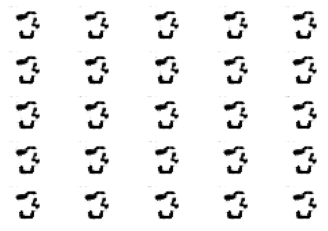

In [28]:
X_eval, y_eval = generate_fake_samples(g_model=gan_model.layers[0], latent_dim=100, n_samples=25)

_plot(X_eval[:, :, :, 0])